## Modeling Uncertainty in Random Forests and Neural Networks

This notebook produces scikit-garden and TFP predicitons for LAI and fAPAR for the NAIVE database for each biome and, using the validation datasets, compares the predicted confidence intervals to:
1. Epistemic error (Cross validation error)
2. Aleatoric error (The standard deviation of LAI and fAPAR given in the algorithm)

## Inital Setup

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import modules
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [3]:
# List of biome numbers
biomes = [1,2,3,4,5,6,7,8]

In [4]:
# Read in dataset
calbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/calbiomeDictLAI.pkl')
valbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/valbiomeDictLAI.pkl')
# https://drive.google.com/drive/folders/17pL6zsZqGIPmJt5ChS_wxqVuZHdZa4Lg?usp=sharing

In [175]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF'].sample(10000)
    dfval = valbiomeDictLAI[i]['DF'].sample(1000)
    
    # if calbiomeDictLAI[i]['DF'].shape[0] >= 100000:
    #     dfcal = calbiomeDictLAI[i]['DF'].sample(100000)

    calbiomeDictLAI[i]['X_train'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train'] = dfcal[response]

    valbiomeDictLAI[i]['X_test'] = dfval[regressors]
    valbiomeDictLAI[i]['y_test'] = dfval[response]

## Random Forest

### Random Forest Regression

In [ ]:
# Creating and fitting a Random Forest Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rf'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rf'] = valbiomeDictLAI[i]['rf'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])

In [ ]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    valbiomeDictLAI[i]['DF']['y_rf'] = valbiomeDictLAI[i]['rf'].predict(valbiomeDictLAI[i]['X_test'])
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['y_rf'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

### Quantile Regression

In [ ]:
%%html
<style>
table {float:left}
</style>

To use Scikit-Garden:

| Package       | Version          | Notes                    |
|:--------------|:-----------------|:-------------------------|
| python        | 3.7              |                          |
| numpy         | 1.21  (default)  |                          |
| matplotlib    | 3.5   (default)  |                          |
| pandas        | 1.2   (default)  |                          |
| scikit-learn  | 0.22  (default)  |                          |
| scikit-garden | 0.1.3 (default)  | install with conda-forge |
| jupyterlab    | 3.6   (default)  | install with pip         |

In [ ]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

In [ ]:
# Creating a Random Forest Quantile Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rfqr'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

In [ ]:
print(valbiomeDictLAI[1]['rfqr'])

In [ ]:
# Fitting a Random Forest Quantile Regressor for each biome type
for i in biomes:
    valbiomeDictLAI[i]['rfqr'].set_params(max_features=calbiomeDictLAI[i]['X_train'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])

In [ ]:
# Predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['DF']['upper'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['DF']['lower'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['DF']['mid'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

In [ ]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['upper'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['lower'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['mid'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Quantile Regression Forest')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Comparing Random Forest and Quantile Forest

In [ ]:
axes=[]
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['DF']['y_rf'], valbiomeDictLAI[i]['DF']['mid'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
    
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Random Forest")
plt.ylabel("Quantile Forest")
# plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## Neural Network

### Dataframe Structure
`valbiomeDictLAI[biome#]` is a dictionary that will hold another dictionary with naming convention `[type of neural network]_[#neurons]_..._[output_shape]`.

As an example, `nn_80_25_1` is a regular neural network with 2 hidden layers, 80 neurons in the first and 25 in the second, with output shape 1.

Another example would be `pnn_8_1`, which is a probabilistic neural network with 1 hidden layer with 8 neurons and output shape 1.

Each of these dictionaries will hold information about the model, the history, the number of parameters, etc.

### TensorFlow

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [169]:
normalizer = layers.Normalization(input_shape=[5,], axis=None)
normalizer.adapt(np.array(calbiomeDictLAI[7]['X_train']))

name = 'nn_80_1'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    layers.Dense(80, activation='relu'),
    # layers.Dense(25, activation='relu'),
    layers.Dense(1)])

valbiomeDictLAI[biome][name]['model'].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_34 (Normaliza  (None, 5)                3         
 tion)                                                           
                                                                 
 dense_28 (Dense)            (None, 80)                480       
                                                                 
 dense_29 (Dense)            (None, 1)                 81        
                                                                 
Total params: 564
Trainable params: 561
Non-trainable params: 3
_________________________________________________________________


Epoch 1/50
313/313 [==============================] - 1s 2ms/step - loss: 235.6096 - root_mean_squared_error: 15.3496
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 148.6105 - root_mean_squared_error: 12.1906
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 122.8888 - root_mean_squared_error: 11.0855
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 109.8112 - root_mean_squared_error: 10.4791
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 106.2631 - root_mean_squared_error: 10.3084
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 104.2305 - root_mean_squared_error: 10.2093
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 102.3076 - root_mean_squared_error: 10.1147
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: 100.5514 - root_mean_squared_error: 10.0275
Epoch 9/50
313/313 [==============================] - 1s

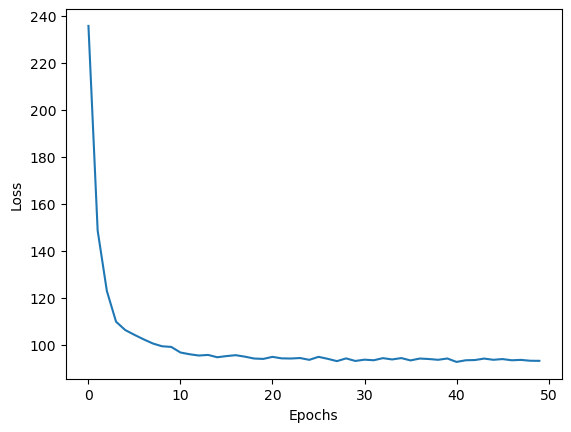

In [170]:
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[7][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

Text(0.5, 1.0, 'nn_80_1')

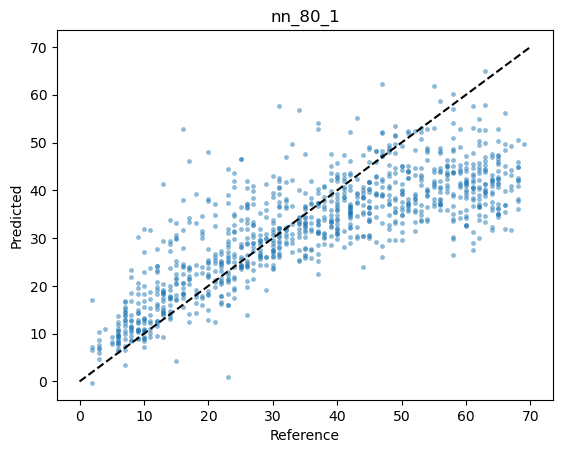

In [171]:
y_model = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test'])
plt.scatter(valbiomeDictLAI[biome]['y_test'], y_model, alpha=0.5, s=12, lw=0)
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference")
plt.ylabel("Predicted")
plt.title(name)

### Aleatoric Uncertainty

#### Background Information
**Aleatoric Uncertainity**, or data uncertainty, relates to the data generating process that produces our data and captures the unpredictable randomness in outcomes when repeating the same experiement with exactly the same settings many times. The most important fact about aleatoric uncertainty is that it cannot be reduced by adding more data.

#### Defining a log-likelihood Loss Function
We first create a function that takes some data and distribution object and computes log-liklihood of the data given to the distribution. Like any TensorFlow-compatible loss function, the function takes true values `y_true` and predictions `y_pred`. Then we compute the log-PDF with the `log_prob()` method and reverse the sign to maximize the liklihood. 

In [21]:
negloglik = lambda y_true, y_pred: -y_pred.log_prob(y_true)

#### Defining the Model
Our model has 2 types of layers. The first type is a regular Keras `Dense` layer, whose purpose is to parametrize the distribution in the second layer.

The second type of layer is `IndependentNormal`. Probabilistic layers in TFP are wrappers around distribution objects that allow for smooth integration of TFP distribution with regular TensorFlow layers. The `event_shpae()` represent the dimentionality of the output.

`.params_size()` is a very convenient method that returns the number of parameters necessary to parametrize a distribution given its event shape. In this case, the method returns 2, as we are parameterizing a 1 dimensional `IndependentNormal` which has 2 parameters — mean and standard deviation.

In [22]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['nn'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(80, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(tfpl.IndependentNormal.params_size(1)),
        tfpl.IndependentNormal(event_shape=1)])

In [23]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['nn'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(tfpl.IndependentNormal.params_size(80)),
        tfpl.IndependentNormal(event_shape=80),
        layers.Dense(tfpl.IndependentNormal.params_size(25)),
        tfpl.IndependentNormal(event_shape=25),
        layers.Dense(tfpl.IndependentNormal.params_size(1)),
        tfpl.IndependentNormal(event_shape=1)])
    
     valbiomeDictLAI[i]['nn'].compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=negloglik,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [25]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
#             self.model.stop_training = True

#### Training the Model
Train the model for 50 epochs.

In [ ]:
for i in [1]:
    callbacks = myCallback()
    valbiomeDictLAI[i]['nn_history'] = valbiomeDictLAI[i]['nn'].fit(calbiomeDictLAI[i]['X_train'].to_numpy(), calbiomeDictLAI[i]['y_train'].to_numpy(), epochs=50, validation_split=0.2, verbose=1)

In [ ]:
valbiomeDictLAI[i]['DF']['y_nn'] = valbiomeDictLAI[i]['nn'].predict(valbiomeDictLAI[i]['X_test'])

In [ ]:
y_mean = valbiomeDictLAI[i]['nn'](valbiomeDictLAI[i]['X_test'].to_numpy()).mean()
y_sd = valbiomeDictLAI[i]['nn'](valbiomeDictLAI[i]['X_test'].to_numpy()).stddev()

y_hat_lower = y_mean - 2 * y_sd
y_hat_upper = y_mean + 2 * y_sd

In [ ]:
print(y_sd)
print(y_mean)

In [ ]:
axes = []
for i in [1]:
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], y_sd, s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

In [ ]:
sklearn.metrics.mean_squared_error(valbiomeDictLAI[1]['y_test'], valbiomeDictLAI[1]['DF']['y_nn'], squared=False)

In [ ]:
valbiomeDictLAI[2]['nn'].summary()

### Epistemic Uncertainty

#### Sources
Probabilistic regression with Tensorflow: https://ekamperi.github.io/machine%20learning/2021/01/07/probabilistic-regression-with-tensorflow.html \
Modeling uncertainity in neural networks with TensorFlow Probability: https://towardsdatascience.com/modeling-uncertainty-in-neural-networks-with-tensorflow-probability-d519a4426e9c

#### Background Information
**Epistemic uncertainty** or model uncertainty is related to our knowledge regarding the data generating process. For example, the uncertainty regarding which parameters accurately model the experimental data. 

Epistemic uncertainty can be decreased by adding more training data. Its modeling is realized by enabling a neural network's wieghts to be probabilistic rather than deterministic,

#### Prior Distribution
Defining a prior distribution for model's weights. Adopting a normal distribution as a prior is a good way to initalize a probabilistic neural network. As the **central limit theorem** assets, a properly normalized sum of samples will approximate a nromal distribution no matter the actual underlying distribution.

We used `MultivariateNormalDiag()` (a multivariate normal distribution wtih a diagonal covariance matrix), with zero mean (`loc=tf.zeros(n)`) and a standard deviation of 1 (`scale_diag=tf.ones(n)`). The we use the `DistrubtionLambda()` function to transform the distribution object into a Keras-compatible layer, and inject it into a `keras.Sequantial()` model. 

In [7]:
def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

#### Posterior Distribution
Unlike the prior distribution, we want the posterior to be trainable. We will use a multivariate Gaussian distribution, but allows off-diagonal elements in the covariance matrix to be non-zero. 
There are 3 ways to parameterize such a distribution:
1. in terms of a positive definite covariance matrix
2. via a positive definite precision matrix
3. with a lower-triangular matrix with positive-valued diagonal entries (can be obtained via **Cholesky decomposition**)

In this case, we use method 3 with `MultivariateNromalTriL()` (*TriL* stands for *triangular lower*). We will use `VariableLayer()` that generates a trainable variable to parametrize `MultivariateNromalTriL()`, using `.params_size()` to get a precise number of parameters necessary.

In [8]:
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

#### Defining the model
Before defining the model, we first normalize the inputs using the Keras `Normalization()` layer to transform the data to be on a similar scale. We call the `adapt()` method on our input data to get the mean and standard deviation of the dataset and set our normalization layer to use those parameters. And so the first layer of our model normalizes our data.

We then define the probabilistic layers in our neural network using the `DenseVariational()` function, specifying input/output shape, with the prior and posterior distributions previously defined. Note that the prior and posterior functions should be passed as objects without actually calling them. 

The last 2 parameters specified in the variational layer are related to **Kullback_Leibler divergence** (KL divergence). Because this term is coputed on a different subset of data than the second term in ELBO, we need to rescale it so that it's unbiased. `kl_use_exact()` controls if we want to compute KL divergence analytically or use and empirical approximation (default is `False`: empirical approximation).

This layer implements *Bayes by backprop*, an approximate method that can be used for efficient weight uncertainty estimation in neural networks. It returns a point estimate of the output, but its weights (and biases) are probabilistic.

Use a **relu** activation function to add non-linearity to the network.

In [176]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer
normalizer = layers.Normalization(input_shape=[5,], axis=None)
normalizer.adapt(np.array(calbiomeDictLAI[7]['X_train']))

name = 'pnn_8_1'
biome = 7

valbiomeDictLAI[biome][name] = dict()

valbiomeDictLAI[biome][name]['model'] = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(units=8,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[1]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    # tfpl.DenseVariational(units=25,
    #                       make_prior_fn=get_prior,
    #                       make_posterior_fn=get_posterior,
    #                       kl_weight=1/calbiomeDictLAI[1]['X_train'].shape[0],
    #                       kl_use_exact=False,
    #                       activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[1]['X_train'].shape[0],
                          kl_use_exact=False)
])

def nll(y_true, y_pred):
                   dist = tfp.distributions.Normal(loc=y_pred, scale=1.0)
                   return tf.reduce_sum(-dist.log_prob(y_true))

valbiomeDictLAI[biome][name]['model'].compile(loss=nll, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
valbiomeDictLAI[biome][name]['model'].summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_36 (Normaliza  (None, 5)                3         
 tion)                                                           
                                                                 
 dense_variational_53 (Dense  (None, 8)                1224      
 Variational)                                                    
                                                                 
 dense_variational_54 (Dense  (None, 1)                54        
 Variational)                                                    
                                                                 
Total params: 1,281
Trainable params: 1,278
Non-trainable params: 3
_________________________________________________________________


#### Train the Model
Train the model for 50 epochs and plot the loss function to confirm that the algorithm as converged.

In [ ]:
# Train the model for 50 epochs
callbacks = myCallback()
valbiomeDictLAI[biome][name]['history'] = valbiomeDictLAI[biome][name]['model'].fit(calbiomeDictLAI[biome]['X_train'].to_numpy(), calbiomeDictLAI[biome]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(valbiomeDictLAI[biome][name]['history'].history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

Epoch 1/50
313/313 [==============================] - 16s 6ms/step - loss: 8651.9736 - root_mean_squared_error: 23.2193
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 3623.6736 - root_mean_squared_error: 14.9966
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 3306.0818 - root_mean_squared_error: 14.3165
Epoch 4/50
313/313 [==============================] - 2s 7ms/step - loss: 3109.3091 - root_mean_squared_error: 13.8839
Epoch 5/50
313/313 [==============================] - 2s 7ms/step - loss: 3079.6553 - root_mean_squared_error: 13.8142
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 2925.3911 - root_mean_squared_error: 13.4578
Epoch 7/50
313/313 [==============================] - 2s 7ms/step - loss: 2805.0044 - root_mean_squared_error: 13.1735
Epoch 8/50
313/313 [==============================] - 2s 7ms/step - loss: 2741.2710 - root_mean_squared_error: 13.0236
Epoch 9/50
313/313 [===========================

Text(0.5, 1.0, 'NN 80-25-1p')

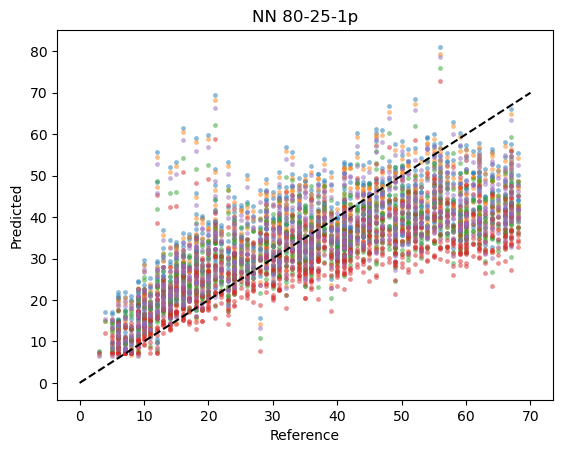

In [155]:
for i in range(5):
    y_model = valbiomeDictLAI[biome][name]['model'](valbiomeDictLAI[biome]['X_test'])
    plt.scatter(valbiomeDictLAI[biome]['y_test'], y_model, alpha=0.5, s=12, lw=0)
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference")
plt.ylabel("Predicted")
plt.title("NN 80-25-1p")

## Questions
1. Which predictor is better in general in terms of RMSE  and bias overall and for unsaturated and saturated validation samples.
2. What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)
3. What is the relative size of the standard deviation of LAI or fAPAR absolute residual to the prediction confidence interval
4. Does the prediction confidence interval change as the sample size decreases?

In [ ]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df_100'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            'rmse': metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_' + predictor], squared=False),
            'residual': valbiomeDictLAI[biome]['DF']['y_' + predictor] - valbiomeDictLAI[biome]['y_test'],
            # 'sd': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'pi_mag': valbiomeDictLAI[biome]['DF']['upper'] - valbiomeDictLAI[biome]['DF']['lower'],
            'sample_size': 100,
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df_100'] = pd.concat([valbiomeDictLAI[biome]['result_df'], df])

### Question 1
Which predictor is better in general in terms of RMSE and bias overall and for unsaturated and saturated validation samples. 

In [ ]:
# kde plots of both methods on the same graph showing predicted versus actual
fig, ax = plt.subplots()
sns.kdeplot(data=valbiomeDictLAI[i]['result_df_100'], x='y_true', y='y_pred', hue='predictor')
plt.plot([-10, 80], [-10, 80], 'k--')
plt.xlim([-10, 80])
plt.ylim([-10, 80])

In [ ]:
# Scatter plots (with 1000 samples only) of each estimated versus predicted together with confidence intervals indicated using symbols rather than bars


### Question 2
What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
sns.kdeplot(data=valbiomeDictLAI[i]['result_df_100'], x='y_true', y='residual', hue='predictor')
plt.plot([0, 80], [0, 0], 'k--')

### Question 3
What is the relative size of the standard deviation of LAI or fAPAR  absolute residual to the  prediction confidence interval

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
sns.kdeplot(data=valbiomeDictLAI[i]['result_df_100'], x='y_true', y='stddev', hue='predictor')
plt.plot([-10, 80], [-10, 80], 'k--')

### Question 4
Does the prediction confidence interval change as the sample size decreases?  

In [ ]:
# Sample 50% of the calibration data
for i in biomes:
    calbiomeDictLAI[i]['X_train_50'] = calbiomeDictLAI[i]['X_train'].sample(frac=0.5)
    calbiomeDictLAI[i]['y_train_50'] = calbiomeDictLAI[i]['y_train'].sample(frac=0.5)

In [ ]:
# Create and fit a Random Forest Quantile Regressor using 50% of the calibration samples
for i in biomes:
    valbiomeDictLAI[i]['rfqr_50'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rfqr_50'].set_params(max_features=calbiomeDictLAI[i]['X_train_50'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr_50'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train_50'], calbiomeDictLAI[i]['y_train_50'])

In [ ]:
# Predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['DF']['upper_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['DF']['lower_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['DF']['mid_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

In [ ]:
# Create and fit a Neural Network using 50% of the calibration samples

In [ ]:
# Predicting a Neural Network for each biome type with 95% prediction confidence interval

In [ ]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df_50'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            'rmse': metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_' + predictor], squared=False),
            'residual': valbiomeDictLAI[biome]['DF']['y_' + predictor] - valbiomeDictLAI[biome]['y_test'],
            # 'sd': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'pi_mag': valbiomeDictLAI[biome]['DF']['upper_50'] - valbiomeDictLAI[biome]['DF']['lower_50'],
            'sample_size': 50,
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df_50'] = pd.concat([valbiomeDictLAI[biome]['result_df_50'], df])

In [ ]:
# Plot the prediction confidence intervals magnitude versus the true value (maybe a kde plot) for 100% and 50%
data = pd.concat([valbiomeDictLAI[biome]['result_df_50'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf'], valbiomeDictLAI[biome]['result_df_100'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf']])
sns.kdeplot(data=data, x='y_true', y='pi_mag', hue='sample_size')

In [ ]:
sns.scatterplot(data=valbiomeDictLAI[biome]['result_df_50'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf'], x='y_true', y='pi_mag')